In [57]:
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os

In [180]:
# Import dff
import h5py
filename = 'C:/Users/Hippolyte Moulle/Documents/LJP_datasets/2018-05-24Run08.h5'
with h5py.File(filename, 'r') as f:
    dff = f['Data']['Brain']['Analysis']['DFF'].value
    dff = np.array(dff)
    time = f['Data']['Brain']['Times'].value
    time = time[1] - time[0]
n = dff.shape[0]
print('Number of time points is ', n)
print('Time increment is ', time)


# Get first signal
signal = dff[:, 100]
#signal = np.expand_dims(signal, 1)
print('Signal shape is ', signal.shape)

Number of time points is  3000
Time increment is  [0.4]
Signal shape is  (3000,)


Size of exponential is  (53,)


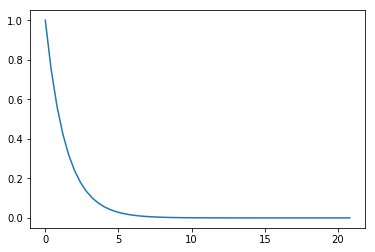

In [181]:
# Build exponential kernal
expdecay = 3.5
exptime = np.arange(6*expdecay/time)
expkern = np.exp(-exptime/expdecay)
elen = expkern.shape[0]
plt.plot(time*np.arange(elen), expkern)
print('Size of exponential is ', expkern.shape)

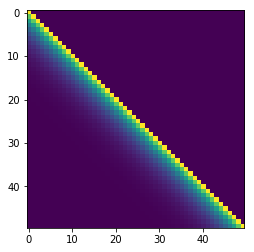

In [182]:
# Build exponential matrix
expmat = np.zeros((n+2*(elen-1), n+elen-1))
for kern in range(n+elen-1):
    expmat[kern:kern+elen, kern] = expkern
expmat = expmat[elen-1:n+elen-1]
plt.imshow(expmat[-50:, -50:])

In [183]:
# Define dataset for keras model
X = expmat
y = signal
print(X.shape, y.shape)

(3000, 3052) (3000,)


In [184]:
# Build keras model
from keras.layers import Dense
from keras.models import Sequential
from keras.constraints import MinMaxNorm, NonNeg
model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], use_bias=False, kernel_constraint=NonNeg()))
#model.add(Dense(1, input_dim=X.shape[1], use_bias=False, kernel_constraint=MinMaxNorm(min_value=0.0, max_value=1.0, rate=1.0, axis=0)))
model.add(Dense(1, kernel_constraint=NonNeg(), bias_constraint=NonNeg()))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1)                 3052      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 2         
Total params: 3,054
Trainable params: 3,054
Non-trainable params: 0
_________________________________________________________________


In [185]:
# Train model
model.fit(X, y, epochs=50)

Epoch 1/50
3000/3000 [==============================] - 1s 194us/step - loss: 0.0016 - mean_absolute_error: 0.0298
Epoch 2/50
3000/3000 [==============================] - 0s 36us/step - loss: 4.3344e-04 - mean_absolute_error: 0.0156
Epoch 3/50
3000/3000 [==============================] - 0s 38us/step - loss: 2.4086e-04 - mean_absolute_error: 0.0118
Epoch 4/50
3000/3000 [==============================] - 0s 37us/step - loss: 1.7262e-04 - mean_absolute_error: 0.0102
Epoch 5/50
3000/3000 [==============================] - 0s 40us/step - loss: 1.4130e-04 - mean_absolute_error: 0.0092
Epoch 6/50
3000/3000 [==============================] - 0s 40us/step - loss: 1.2309e-04 - mean_absolute_error: 0.0087
Epoch 7/50
3000/3000 [==============================] - 0s 39us/step - loss: 1.0878e-04 - mean_absolute_error: 0.0081
Epoch 8/50
3000/3000 [==============================] - 0s 38us/step - loss: 1.0481e-04 - mean_absolute_error: 0.0078
Epoch 9/50
3000/3000 [==============================] - 0s 

[array([[ 7.8100635e-07],
       [-0.0000000e+00],
       [ 3.3040661e-02],
       ...,
       [ 3.9703385e-03],
       [ 3.4722112e-02],
       [-0.0000000e+00]], dtype=float32), array([[0.6864605]], dtype=float32), array([-0.], dtype=float32)]
(3052, 1) (1, 1) (1,)


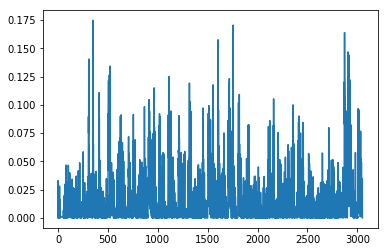

In [189]:
temp = model.get_weights()
print(temp)
print(temp[0].shape, temp[1].shape, temp[2].shape)
toplot = 200
plt.plot(temp[0])

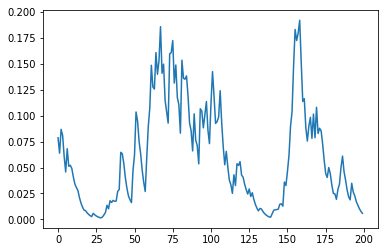

In [188]:
plt.plot(np.matmul(X, temp[0])[500:500+toplot])

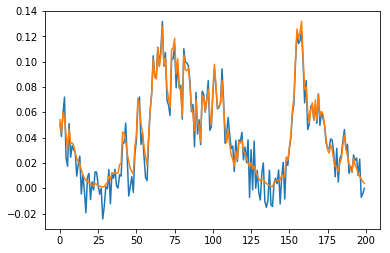

In [187]:
plt.plot(y[500:500+toplot])
plt.plot(temp[1]*np.matmul(X, temp[0])[500:500+toplot]+temp[2])